In [1]:
# read data: 30 ICs 
import nipype.interfaces.io as nio
import os
PD_ICA_file='/templateflow/PD_ICAs';
ICs_list=list(range(30))
ICs_list=["{:0>4d}".format(x) for x in ICs_list]
# file import
ds_ic = nio.DataGrabber(infields=['IC_id'])
ds_ic.inputs.base_directory = PD_ICA_file # database
ds_ic.inputs.template = 'melodic_IC_%4s.nii.gz' # from cwd
ds_ic.inputs.sort_filelist = True
ds_ic.inputs.IC_id = ICs_list
res_ic = ds_ic.run()
ic_list=res_ic.outputs.outfiles

200920-22:57:45,582 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0


In [2]:
import os
import nibabel as nib
from nilearn.image import resample_to_img
from nilearn.image import math_img
import numpy as np
from scipy import stats

ICA_AD_PATH ='/output/PPMI_DBM_AD/'
ICA_AD_sub_PATH ='/output/PPMI_DBM_AD/sub_dbm/'

if not os.path.exists(ICA_AD_PATH):
    os.makedirs(ICA_AD_PATH)
merged_file = ICA_AD_PATH+'reshape_merged_dbm3_masked.nii'
sub_list_file = ICA_AD_PATH+'subject_IDs.csv'

merged_img=nib.load(merged_file)
N_sub = merged_img.shape[3]

i_PD_IC=0
import nibabel as nib
PD_ICA_img=nib.load(ic_list[i_PD_IC]);
corr_list=[]

for i_sub in range(N_sub):
    #print(str(i_sub))
    sub_img = merged_img.slicer[:,:,:,i_sub]
    #sub_img_re = resample_to_img(sub_img, PD_ICA_img)
    #nib.save(sub_img, ICA_AD_sub_PATH+'sub-'+str(i_sub)+'_dbm.nii.gz')
    # n
    ic_data = PD_ICA_img.get_fdata().reshape(-1);
    sub_dat = sub_img.get_fdata().reshape(-1);
    nz_pos=np.flatnonzero(ic_data)
    ic_val =list(ic_data.ravel()[nz_pos])
    sub_val=list(stats.zscore(sub_dat.ravel()[nz_pos]))
    corr_list.append(np.corrcoef(ic_val, sub_val)[0,1])

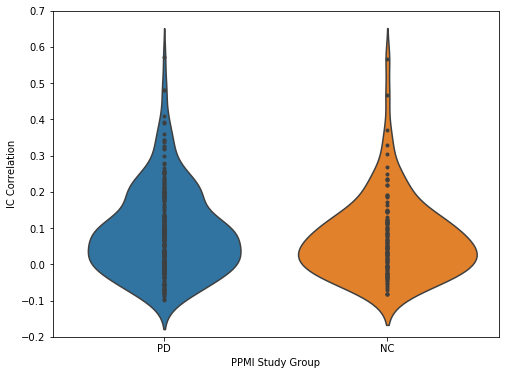

In [6]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sub_list =  pd.read_csv(sub_list_file, sep=',', header=0, index_col=0)
len(sub_list)
sub_label= ['PD' if x==1 else 'NC' for x in list(sub_list['PD'])]
ad_group_corr=pd.DataFrame({'IC Correlation': corr_list, 'PPMI Study Group': sub_label})
plt.figure(1, figsize=(8, 6))
ax = sns.violinplot(x="PPMI Study Group", y="IC Correlation", data=ad_group_corr, inner='point', )
#plt.ylim(-0.35, 0.35)
plt.ylim(-0.2, 0.7)
plt.savefig('ad_group_corr_ic0.png')

In [11]:
# reproduce MELODIC ICA (AD pd+nc Jacobian masked)
import time
from nipype.interfaces import fsl
from nipype.interfaces.ants import ANTS, ApplyTransforms,CreateJacobianDeterminantImage

ICA_AD_ICA_PATH ='/output/PPMI_DBM_AD/AD-ICA/'
if not os.path.exists(ICA_AD_ICA_PATH):
    os.makedirs(ICA_AD_ICA_PATH)
merged_file = ICA_AD_PATH+'reshape_merged_dbm3_masked.nii'
t0=time.time()
melodic_setup = fsl.MELODIC()
melodic_setup.inputs.approach = 'tica'
melodic_setup.inputs.in_files = [merged_file]
melodic_setup.inputs.no_bet = True
melodic_setup.inputs.out_all = True
melodic_setup.inputs.out_pca = True
melodic_setup.inputs.out_dir = ICA_AD_ICA_PATH
melodic_setup.inputs.report = True
melodic_setup.cmdline
melodic_setup.run()
print('\tAD MELODIC ICA takes: ', time.time()-t0)

	AD MELODIC ICA takes:  1419.4145150184631


In [3]:
# vis reproduced AD ICs 30
from nilearn import plotting
GROUPS=['PD','ET','NC']
AD_RE_IC_DIR='/output/PPMI_DBM_AD/AD-ICA/stats/'
prob_file=list(range(20)); thz_file=list(range(31));
prob_file=[ AD_RE_IC_DIR+'probmap_'+str(x)+'.nii.gz' for x in prob_file[1:]]
thz_file =[ AD_RE_IC_DIR+'thresh_zstat'+str(x)+'.nii.gz' for x in thz_file[1:]]

OUT_DIR='/output/PPMI_DBM_AD/pics_local-ICA/'
atlas_09_masked='/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_T1w.nii.gz'
N_ic = len(thz_file)
i_ic=0
VMIN= 3; VMAX=16; 
for i_ic in range(N_ic):
    plotting.plot_stat_map(thz_file[i_ic], bg_img=atlas_09_masked, display_mode='z', threshold=3, vmax=VMAX, \
                           title="AD-recal-IC "+str(i_ic), draw_cross=False, cut_coords=[-16, -12, -7, -2,  8, 14, 20, 70], \
                           output_file=OUT_DIR+'/AD_re-IC-'+str(i_ic)+'.png')

In [7]:
# read data: 30 ICs 
import nipype.interfaces.io as nio
import os
PD_ICA_file='/templateflow/PD_ICAs';
ICs_list=list(range(30))
ICs_list=["{:0>4d}".format(x) for x in ICs_list]
# file import
ds_ic = nio.DataGrabber(infields=['IC_id'])
ds_ic.inputs.base_directory = PD_ICA_file # database
ds_ic.inputs.template = 'melodic_IC_%4s.nii.gz' # from cwd
ds_ic.inputs.sort_filelist = True
ds_ic.inputs.IC_id = ICs_list
res_ic = ds_ic.run()
ic_list=res_ic.outputs.outfiles
N_ic=len(ic_list);
ic_names=[str(x) for x in list(range(30))]

30


In [23]:
# IC recal-IC differences
from nipype.interfaces import fsl
from nilearn.image import math_img
import nibabel as nib
import numpy as np
ic_re_ic_diff=[]; ic_mean_diff=[]; ic_var_diff=[]
for i_ic in range(N_ic):
    ad_ic=nib.load(ic_list[i_ic]); ad_re_ic=nib.load(thz_file[i_ic]);
    img_diff = math_img("img1 - img2", img1=ad_ic, img2=ad_re_ic)
    img_data = img_diff.get_fdata().reshape(-1)
    ic_re_ic_diff.append(img_diff)
    ic_mean_diff.append(np.mean(img_data))
    ic_var_diff.append(np.var(img_data))
    print(i_ic, 'average diff: ', ic_mean_diff[-1])
#plot mean difference     
from matplotlib import pyplot as plt
plt.plot(ic_mean_diff)
plt.ylim(-.1,.1)
plt.xlabel('ICs')
plt.ylabel('Differencess(mean)')
plt.title('AD-ICAs and re-cal AD-ICAs')
# svfigs of different images
VMIN= 3; VMAX=16; # vmin=VMIN;
for i_ic in range(N_ic):
    plotting.plot_stat_map(ic_re_ic_diff[i_ic], bg_img=atlas_09_masked, display_mode='z', threshold=3, vmax=VMAX, \
                           title="Diff AD ICs and recal-ICs "+str(i_ic), draw_cross=False, cut_coords=[-16, -12, -7, -2,  8, 14, 20, 70], \
                           output_file=OUT_DIR+'/Diff_AD_re-IC-'+str(i_ic)+'.png')

0 average diff:  0.0034369464044618227
1 average diff:  0.0006429810536455738
2 average diff:  0.0028478061971844984
3 average diff:  0.005432960556548426
4 average diff:  0.006187920731321962
5 average diff:  0.015703192681917114
6 average diff:  -0.0028618710920602967
7 average diff:  0.006236990361675068
8 average diff:  0.0032721490888909977
9 average diff:  0.002472391458773497
10 average diff:  -0.00514804451820348
11 average diff:  0.023022688383239273
12 average diff:  -0.010305901003757492
13 average diff:  0.00029430958365195346
14 average diff:  0.0014538464063427684
15 average diff:  -0.0007489273244758853
16 average diff:  0.005850540449355314
17 average diff:  0.0011430850456778615
18 average diff:  -0.020775823842772993
19 average diff:  0.005532970327312755
20 average diff:  0.013308649094021067
21 average diff:  0.005342668543422894
22 average diff:  4.929422763165418e-05
23 average diff:  0.02150304911641642
24 average diff:  0.0031513221211814076
25 average diff:  -0